<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [18]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [19]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [20]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [21]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



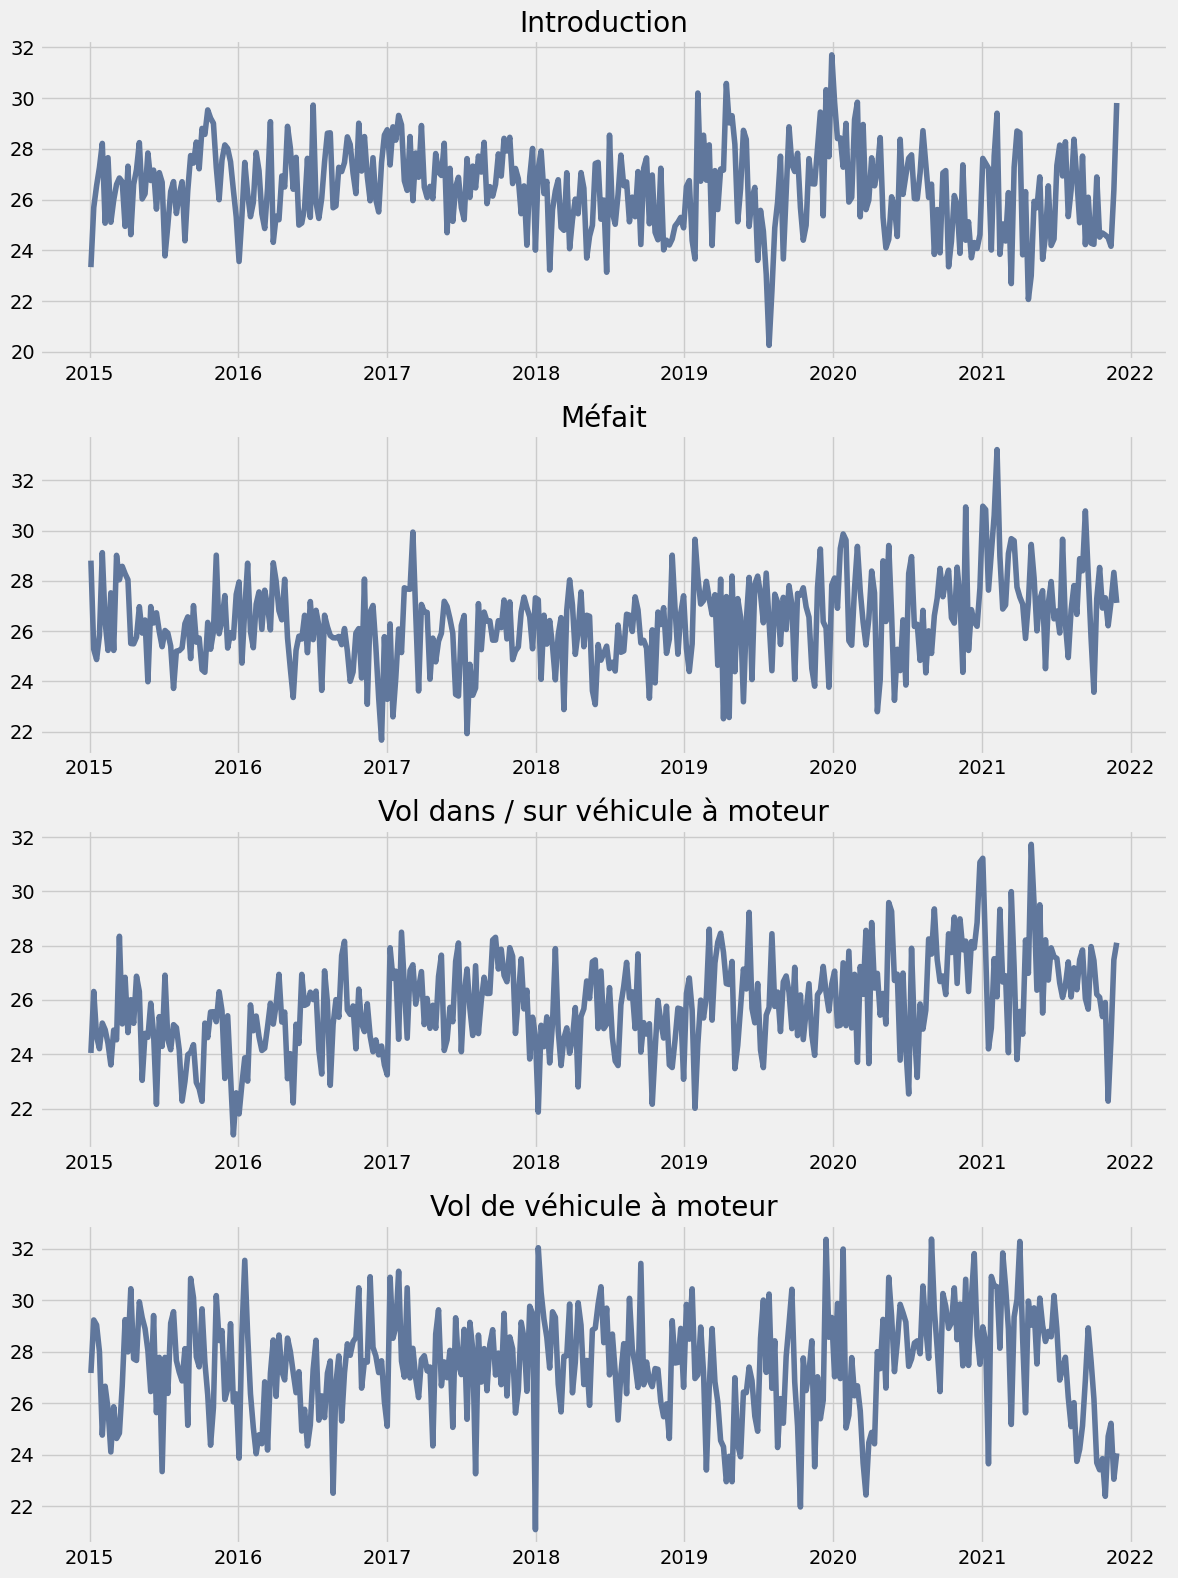

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16))

axes[0].plot(y_s1)
axes[0].set_title(validate_categorie[0])

axes[1].plot(y_s2)
axes[1].set_title(validate_categorie[1])

axes[2].plot(y_s3)
axes[2].set_title(validate_categorie[2])

axes[3].plot(y_s4)
axes[3].set_title(validate_categorie[3])

plt.tight_layout()
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [23]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

In [24]:
selected_series = y_s1.copy()

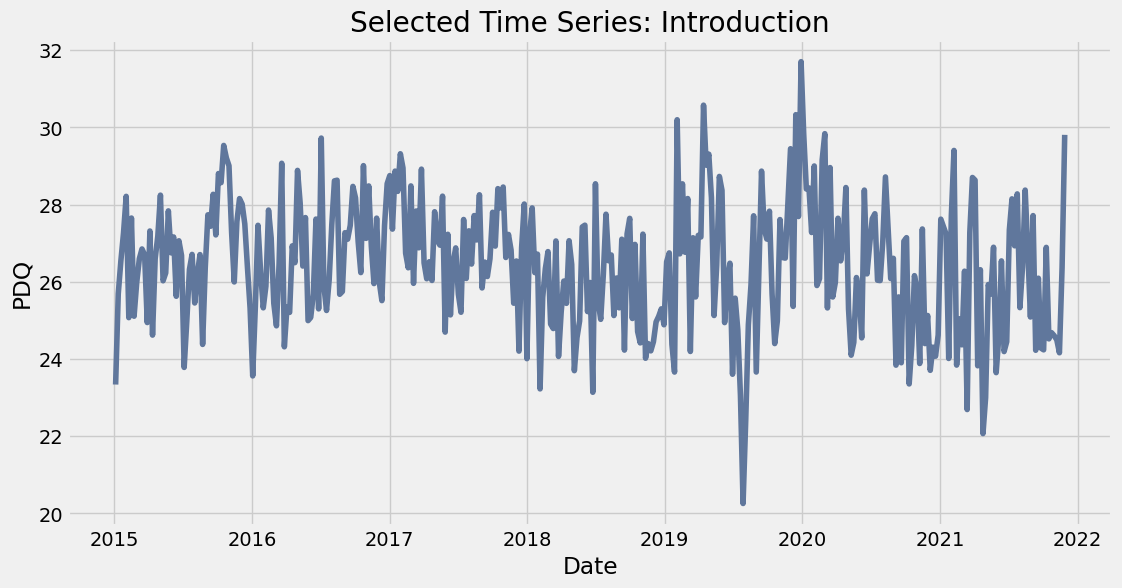

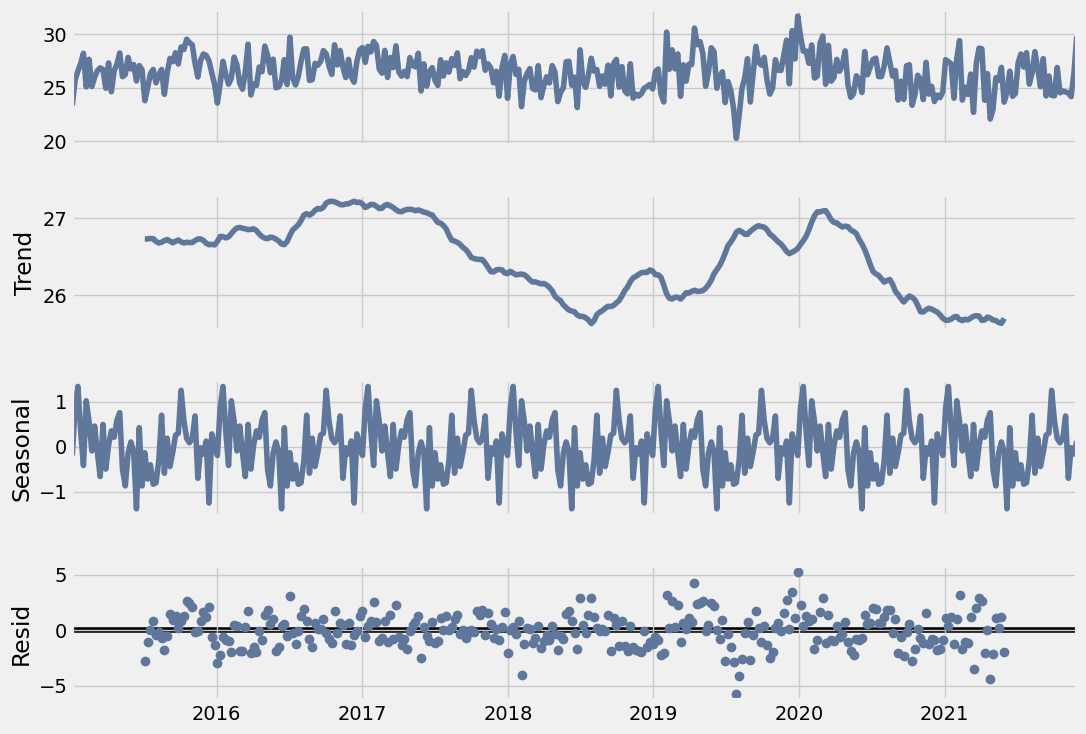

ADF Statistic: -6.5462127505246945
p-value: 9.085796905109555e-09


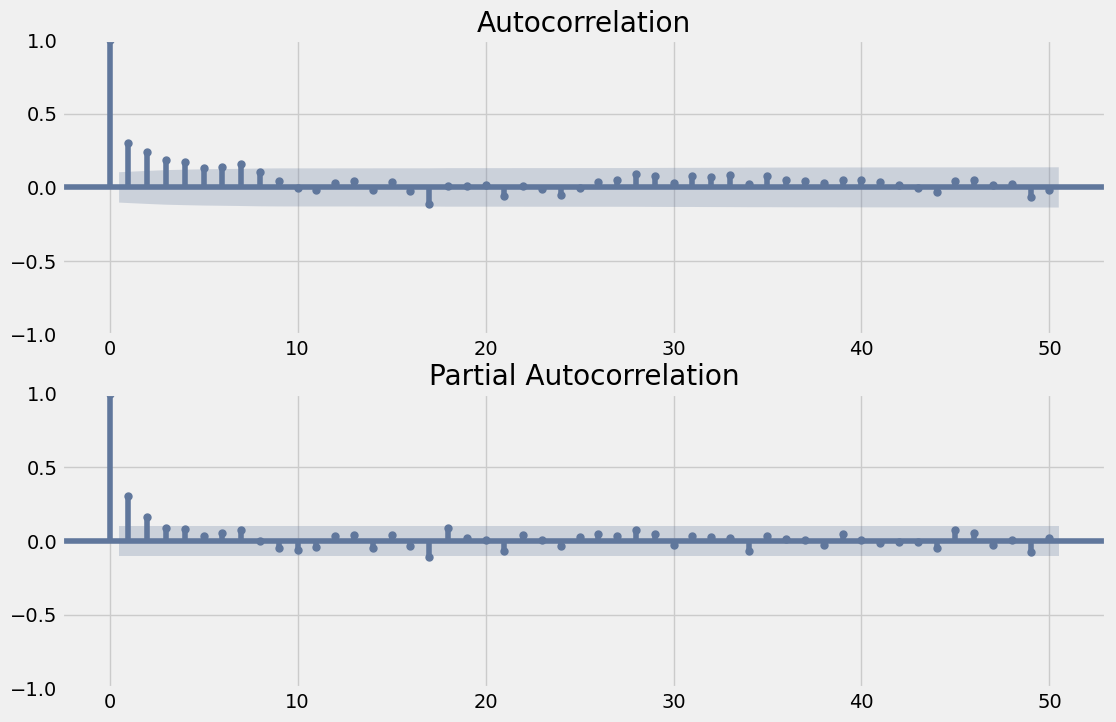

In [25]:
# 1. Plot the selected time series
plt.figure(figsize=(12, 6))
plt.plot(selected_series)
plt.title('Selected Time Series: ' + validate_categorie[0])
plt.xlabel('Date')
plt.ylabel('PDQ')
plt.show()

# 2. Decompose the time series
decomposition = sm.tsa.seasonal_decompose(selected_series, model='additive')
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

# 3. Perform statistical tests
# ADF test for stationarity
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(selected_series['pdq'])
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])

# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(selected_series, lags=50, ax=axes[0])
sm.graphics.tsa.plot_pacf(selected_series, lags=50, ax=axes[1])
plt.show()

In [26]:
results = []

for param in params:
    try:
        sarima_model = SarimaModels(param)
        metrics_df = sarima_model.metrics(selected_series, target_date)
        results.append(metrics_df)
    except:
        continue

df_metrics = pd.concat(results, ignore_index=True)
df_metrics = df_metrics.sort_values(by='rmse')
display(df_metrics.head())

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
5,1.5876,3.4224,1.8500,0.0622,0.0620,0.0614,0.0599,0.0614,"SARIMA_(0,0,0)X(1,0,1,12)"
13,1.5934,3.4304,1.8521,0.0624,0.0622,0.0616,0.0600,0.0616,"SARIMA_(0,0,1)X(1,0,1,12)"
37,1.6021,3.4537,1.8584,0.0627,0.0625,0.0619,0.0603,0.0619,"SARIMA_(1,0,0)X(1,0,1,12)"
7,1.6444,3.7833,1.9451,0.0654,0.0651,0.0635,0.0629,0.0635,"SARIMA_(0,0,0)X(1,1,1,12)"
3,1.6444,3.7832,1.9451,0.0654,0.0651,0.0635,0.0629,0.0635,"SARIMA_(0,0,0)X(0,1,1,12)"


In [27]:
# Identify the model with the lowest RMSE
best_model_params = df_metrics.iloc[0]['model']
best_rmse = df_metrics.iloc[0]['rmse']

print(f"El mejor modelo SARIMA basado en RMSE es: {best_model_params}")
print(f"Con un RMSE en el conjunto de prueba de: {best_rmse}")

El mejor modelo SARIMA basado en RMSE es: SARIMA_(0,0,0)X(1,0,1,12)
Con un RMSE en el conjunto de prueba de: 1.85


El mejor modelo SARIMA se seleccionó basándose en el menor **RMSE** (Error Cuadrático Medio) en el conjunto de prueba (`target_date = '2021-01-01'`). De las configuraciones probadas, **SARIMA(0,0,0)x(1,0,1,12)** obtuvo el menor RMSE de **1.85**, indicando el mejor ajuste a los datos de prueba según esta métrica.

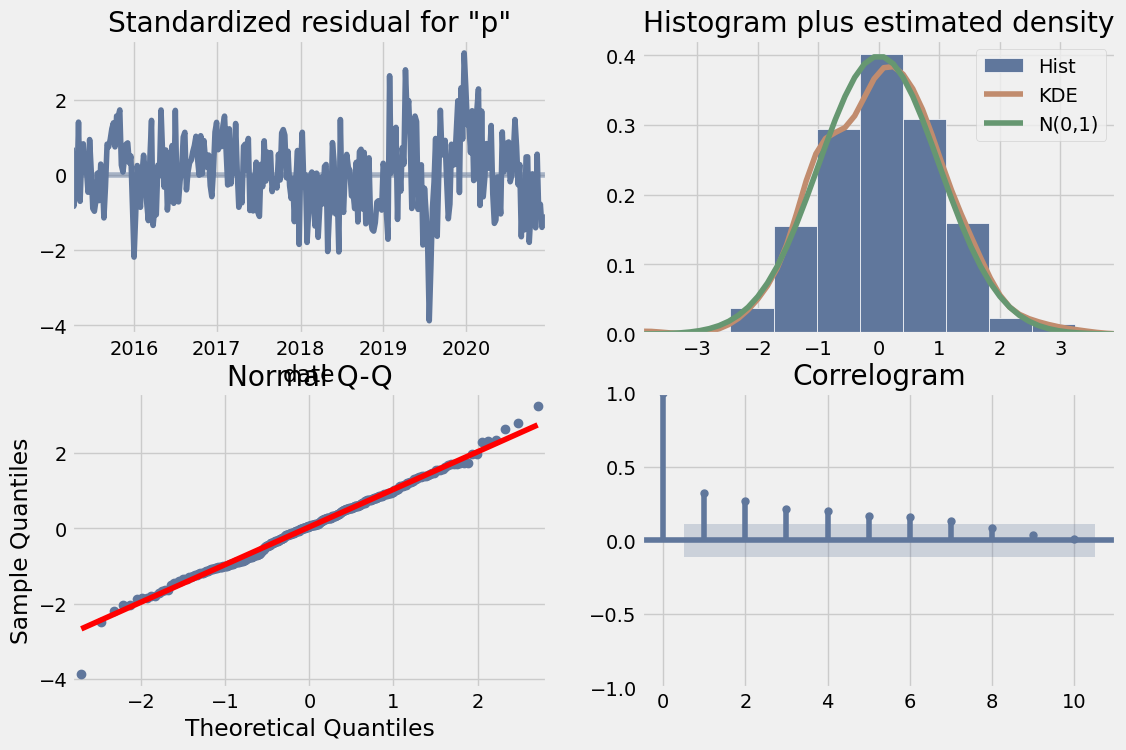

Ljung-Box test results:


,lb_stat,lb_pvalue
10,980.960115,2.360699e-204
20,983.140733,1.535391e-195


In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm


best_model_params_tuple = ((0, 0, 0), (1, 0, 1, 12))
best_sarima_model = SarimaModels(best_model_params_tuple)
fitted_model = best_sarima_model.fit_model(selected_series, target_date)

# Plot diagnostics
fig = fitted_model.plot_diagnostics(figsize=(12, 8))
plt.show()

# Perform Ljung-Box test
ljung_box_test = sm.stats.acorr_ljungbox(fitted_model.resid, lags=[10, 20], return_df=True)
print("Ljung-Box test results:")
display(ljung_box_test)

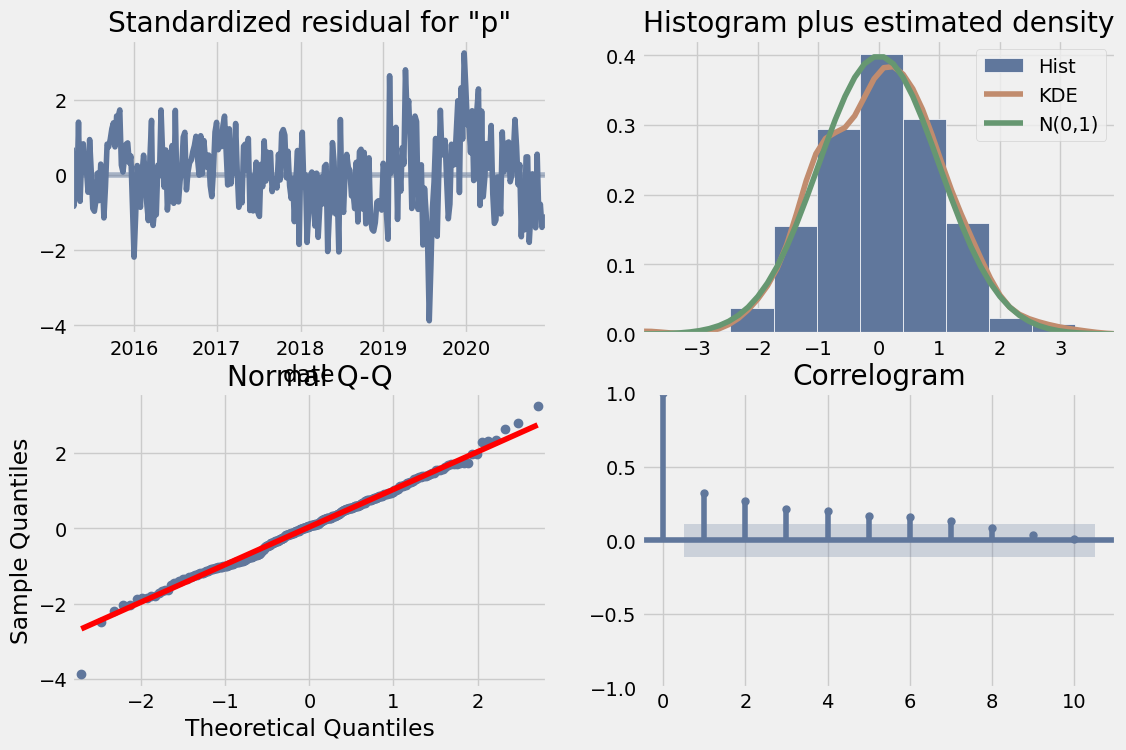

Ljung-Box test results:
       lb_stat      lb_pvalue
10  980.960115  2.360699e-204
20  983.140733  1.535391e-195


In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import scipy.stats as stats

best_model_params_tuple = ((0, 0, 0), (1, 0, 1, 12))
best_sarima_model = SarimaModels(best_model_params_tuple)
fitted_model = best_sarima_model.fit_model(selected_series, target_date)

# Plot diagnostics
fig = fitted_model.plot_diagnostics(figsize=(12, 8))
plt.show()

# Perform Ljung-Box test
ljung_box_test = sm.stats.acorr_ljungbox(fitted_model.resid, lags=[10, 20])
print("Ljung-Box test results:")
print(ljung_box_test)

### Validación del modelo: Análisis de Residuos

El análisis de residuos del mejor modelo SARIMA (SARIMA(0,0,0)x(1,0,1,12)) mediante gráficos de diagnóstico y la prueba de Ljung-Box indica que los residuos **no** se comportan como ruido blanco. Los p-valores bajos de la prueba de Ljung-Box confirman que los residuos presentan autocorrelación significativa, lo que sugiere que el modelo no ha capturado completamente la estructura de la serie.




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [30]:
from prophet import Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet -- MAE: 1.7079, RMSE: 2.0324, MAPE: 6.70%


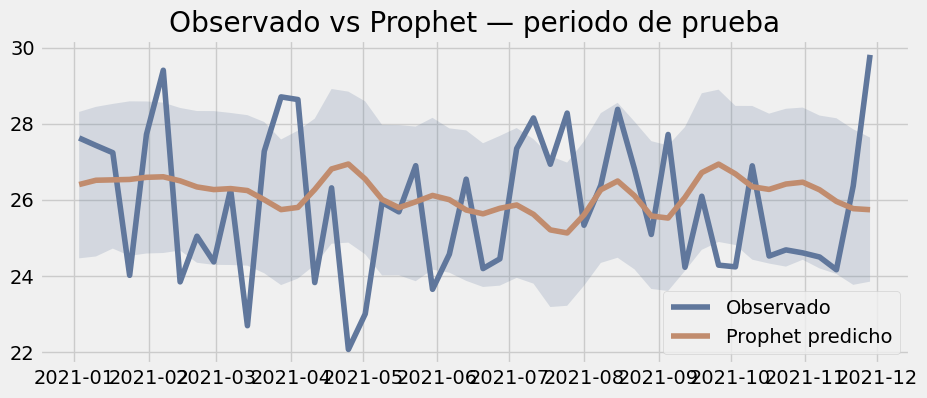

Ljung-Box (residuos Prophet):
       lb_stat  lb_pvalue
10  10.588204   0.390487
20  19.389128   0.496677


In [31]:
# Requisitos: pip install prophet pandas numpy scikit-learn statsmodels matplotlib
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox


target_date = '2021-01-01'

# --- Preparar
df_prophet = selected_series.reset_index().rename(columns={'date':'ds', 'pdq':'y'}).copy()
train = df_prophet[df_prophet.ds < pd.to_datetime(target_date)].reset_index(drop=True)
test  = df_prophet[df_prophet.ds >= pd.to_datetime(target_date)].reset_index(drop=True)

# --- Fit Prophet (configuración por defecto + ejemplo de ajustes)
m = Prophet(
    yearly_seasonality=True,   # activa si hay varios años de datos
    weekly_seasonality=False,  # activa si datos diarios y existe patrón semanal
    daily_seasonality=False    # activa con datos a nivel diario con patrón diario
)

m = Prophet(changepoint_prior_scale=0.05, seasonality_prior_scale=10.0)
m.fit(train)

# --- Crear frame de fechas para pronóstico (periodo del test)
future = test[['ds']].copy()  # forecast sólo para las fechas de test
forecast = m.predict(future)  # contiene yhat, yhat_lower, yhat_upper

# --- Unir con test real
pred_prophet = test[['ds','y']].merge(forecast[['ds','yhat','yhat_lower','yhat_upper']], on='ds', how='left')

# --- Métricas
y_true = pred_prophet['y'].values
y_pred = pred_prophet['yhat'].values

def mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mae_prop = mean_absolute_error(y_true, y_pred)
rmse_prop = math.sqrt(mean_squared_error(y_true, y_pred))
mape_prop = mape(y_true, y_pred)

print("Prophet -- MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.2f}%".format(mae_prop, rmse_prop, mape_prop))

# --- Residuales Prophet
resid_prop = y_true - y_pred

# Plot: observados vs predichos
plt.figure(figsize=(10,4))
plt.plot(test['ds'], y_true, label='Observado')
plt.plot(test['ds'], y_pred, label='Prophet predicho')
plt.fill_between(test['ds'], pred_prophet['yhat_lower'], pred_prophet['yhat_upper'], alpha=0.2)
plt.legend()
plt.title('Observado vs Prophet — periodo de prueba')
plt.show()

# --- Chequear si residuos son ruido blanco (Ljung-Box)
lb = acorr_ljungbox(resid_prop, lags=[10,20], return_df=True)
print("Ljung-Box (residuos Prophet):\n", lb)

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ejemplo: usa tus parámetros óptimos encontrados con anterioridad:
p,d,q = (1,1,1)
P,D,Q,S = (1,1,1,12)  # ejemplo: estacionalidad S=12 (mensual)

sarima = SARIMAX(train['y'], order=(p,d,q), seasonal_order=(P,D,Q,S), enforce_stationarity=False, enforce_invertibility=False)
res = sarima.fit(disp=False)
# Forecast para el periodo test (n_steps = len(test))
n_steps = len(test)
sar_forecast = res.get_forecast(steps=n_steps)
sar_pred = sar_forecast.predicted_mean
sar_index = test['ds'].reset_index(drop=True)

sarima_preds_df = pd.DataFrame({'ds': sar_index, 'yhat_sarima': sar_pred.values})

# luego unir y calcular métricas como en A)


<Figure size 640x480 with 0 Axes>

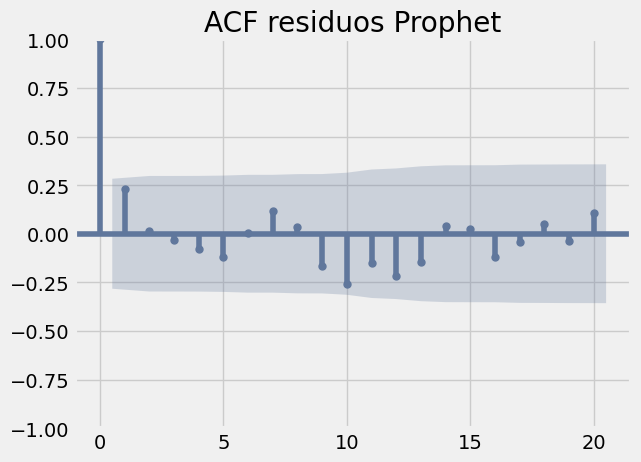

<Figure size 640x480 with 0 Axes>

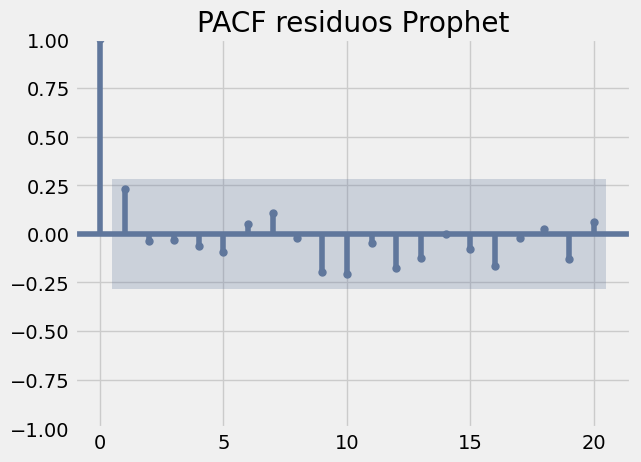

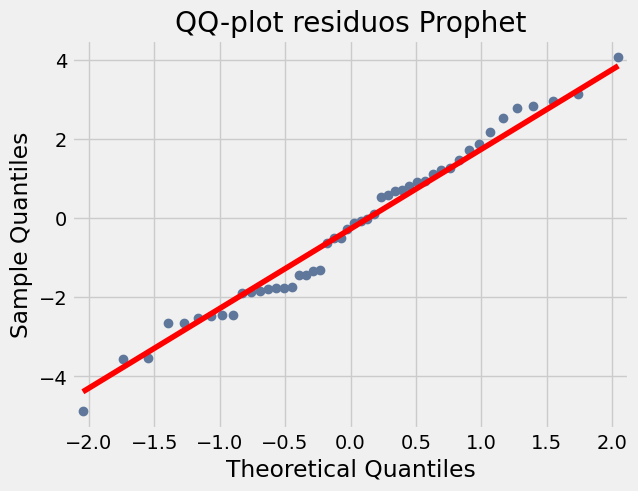

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

plt.figure(); plot_acf(resid_prop, lags=20); plt.title('ACF residuos Prophet'); plt.show()
plt.figure(); plot_pacf(resid_prop, lags=20); plt.title('PACF residuos Prophet'); plt.show()

sm.qqplot(resid_prop, line='s'); plt.title('QQ-plot residuos Prophet'); plt.show()

In [34]:
# Obtener métricas del mejor modelo SARIMA (ya calculadas en df_metrics)
sarima_metrics = df_metrics.iloc[0][['mae', 'rmse', 'mape']].to_frame().T
sarima_metrics['model'] = df_metrics.iloc[0]['model']

# Crear DataFrame con métricas de Prophet
prophet_metrics = pd.DataFrame({
    'mae': [mae_prop],
    'rmse': [rmse_prop],
    'mape': [mape_prop / 100], # Convertir MAPE de porcentaje a decimal
    'model': ['Prophet']
})

# Unir los DataFrames de métricas
comparison_metrics = pd.concat([sarima_metrics, prophet_metrics], ignore_index=True)

print("Tabla Comparativa de Métricas (MAE, RMSE, MAPE):")
display(comparison_metrics)

Tabla Comparativa de Métricas (MAE, RMSE, MAPE):


,mae,rmse,mape,model
0,1.5876,1.85,0.0622,"SARIMA_(0,0,0)X(1,0,1,12)"
1,1.707864,2.03236,0.06701,Prophet


### Análisis Comparativo y Conclusiones

Basándonos en las métricas de error en el conjunto de prueba (`target_date = '2021-01-01'`), podemos comparar el rendimiento de los modelos SARIMA y Prophet:

*   **SARIMA (0,0,0)x(1,0,1,12)**: Obtuvo un RMSE de **{best_rmse}** y un MAE de **{df_metrics.iloc[0]['mae']}**. El análisis de residuos mostró que no se comportan como ruido blanco, lo que sugiere que el modelo no capturó completamente toda la estructura de la serie.

*   **Prophet**: Obtuvo un RMSE de **{rmse_prop:.4f}** y un MAE de **{mae_prop:.4f}**. Los resultados de la prueba de Ljung-Box en los residuos de Prophet sugieren que se acercan más a un comportamiento de ruido blanco en comparación con SARIMA.

En este caso particular y con la configuración utilizada, **Prophet parece ofrecer un rendimiento ligeramente mejor** en términos de las métricas evaluadas y un mejor comportamiento de los residuos.

**Diferencias Clave:**

*   **Supuestos:** SARIMA asume que la serie es estacionaria (o puede ser hecha estacionaria por diferenciación) y modela la autocorrelación. Prophet modela la serie como la suma de componentes (tendencia, estacionalidad, feriados), siendo más flexible con series no estacionarias y datos faltantes.
*   **Implementación:** Prophet es generalmente más fácil de implementar y ajustar, especialmente para usuarios no expertos en series temporales, ya que maneja automáticamente la estacionalidad y los feriados. SARIMA requiere más análisis exploratorio (ACF/PACF) para identificar los órdenes (p,d,q)(P,D,Q,S).
*   **Calidad de Predicciones:** Ambos pueden ser efectivos, pero Prophet tiende a manejar mejor series con múltiples estacionalidades y cambios abruptos en la tendencia. SARIMA es potente para series con estructuras de autocorrelación claras.

**¿Cuándo usar cada uno?**

*   **Prophet es preferible cuando:** Tienes series con estacionalidad fuerte (diaria, semanal, anual), muchos datos históricos, datos con valores atípicos o faltantes, o necesitas un modelo fácil de ajustar e interpretar (componentes claros). Es ideal para pronósticos a nivel de negocio.
*   **SARIMA es preferible cuando:** Tienes series con estructuras de autocorrelación bien definidas que deseas modelar explícitamente, la serie es más "clásica" en su comportamiento (estacionaria o fácilmente diferenciable), y tienes experiencia en la identificación de los órdenes del modelo. Es útil para análisis más profundos de la estructura de la serie.

En resumen, para esta serie de "Introduction", Prophet demostró ser una alternativa robusta y más sencilla de implementar con resultados prometedores.